In [1]:
import torch
import json
import h5py
from PIL import Image, ImageDraw, ImageFont

In [2]:
project_dir = '/home/ubuntu/speaker_prediction'
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')

In [3]:
# load detected results
detected_origin_path = '/home/ubuntu/checkpoints/sgdet-motif109_attri/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [4]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    gt_boxes = groundtruth.bbox
    boxes = prediction.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(int(i))]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    pred_scores = prediction.get_field('pred_scores')
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    
#     mask = pred_rel_score > thres
#     pred_rel_score = pred_rel_score[mask]
#     pred_rel_label = pred_rel_label[mask]
    
    pred_rels = [(pred_labels[int(i[0])], idx2pred[str(j)], pred_labels[int(i[1])]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist()) if j!=0]
    return img_path, gt_boxes, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [5]:
font = ImageFont.truetype('/home/ubuntu/speaker_prediction/visualization/NotoSansJP-Bold.otf', 20)

def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        info = draw_info
        text_width, text_height = font.getsize(info)
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill=color)
        draw.text((x1, y1-text_height), info, font=font)

def print_list(name, input_list, scores):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))
    
def draw_gt_image(img_path, gt_boxes, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = gt_boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, gt_boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels, None)
        print('*' * 50)
        print_list('gt_rels', gt_rels, None)
        print('*' * 50)
    return None

def draw_image(img_path, gt_boxes, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = pred_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('pred_labels', pred_labels, pred_scores)
        print('*' * 50)
        print_list('pred_rels', pred_rels[:20], pred_rel_score)
        print('*' * 50)   
    return None

In [6]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_gt_image(*get_info_by_idx(select_idx, detected_origin_result))
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(f'Image {cand_idx}:')
        draw_gt_image(*get_info_by_idx(cand_idx, detected_origin_result))
        draw_image(*get_info_by_idx(cand_idx, detected_origin_result))

2837


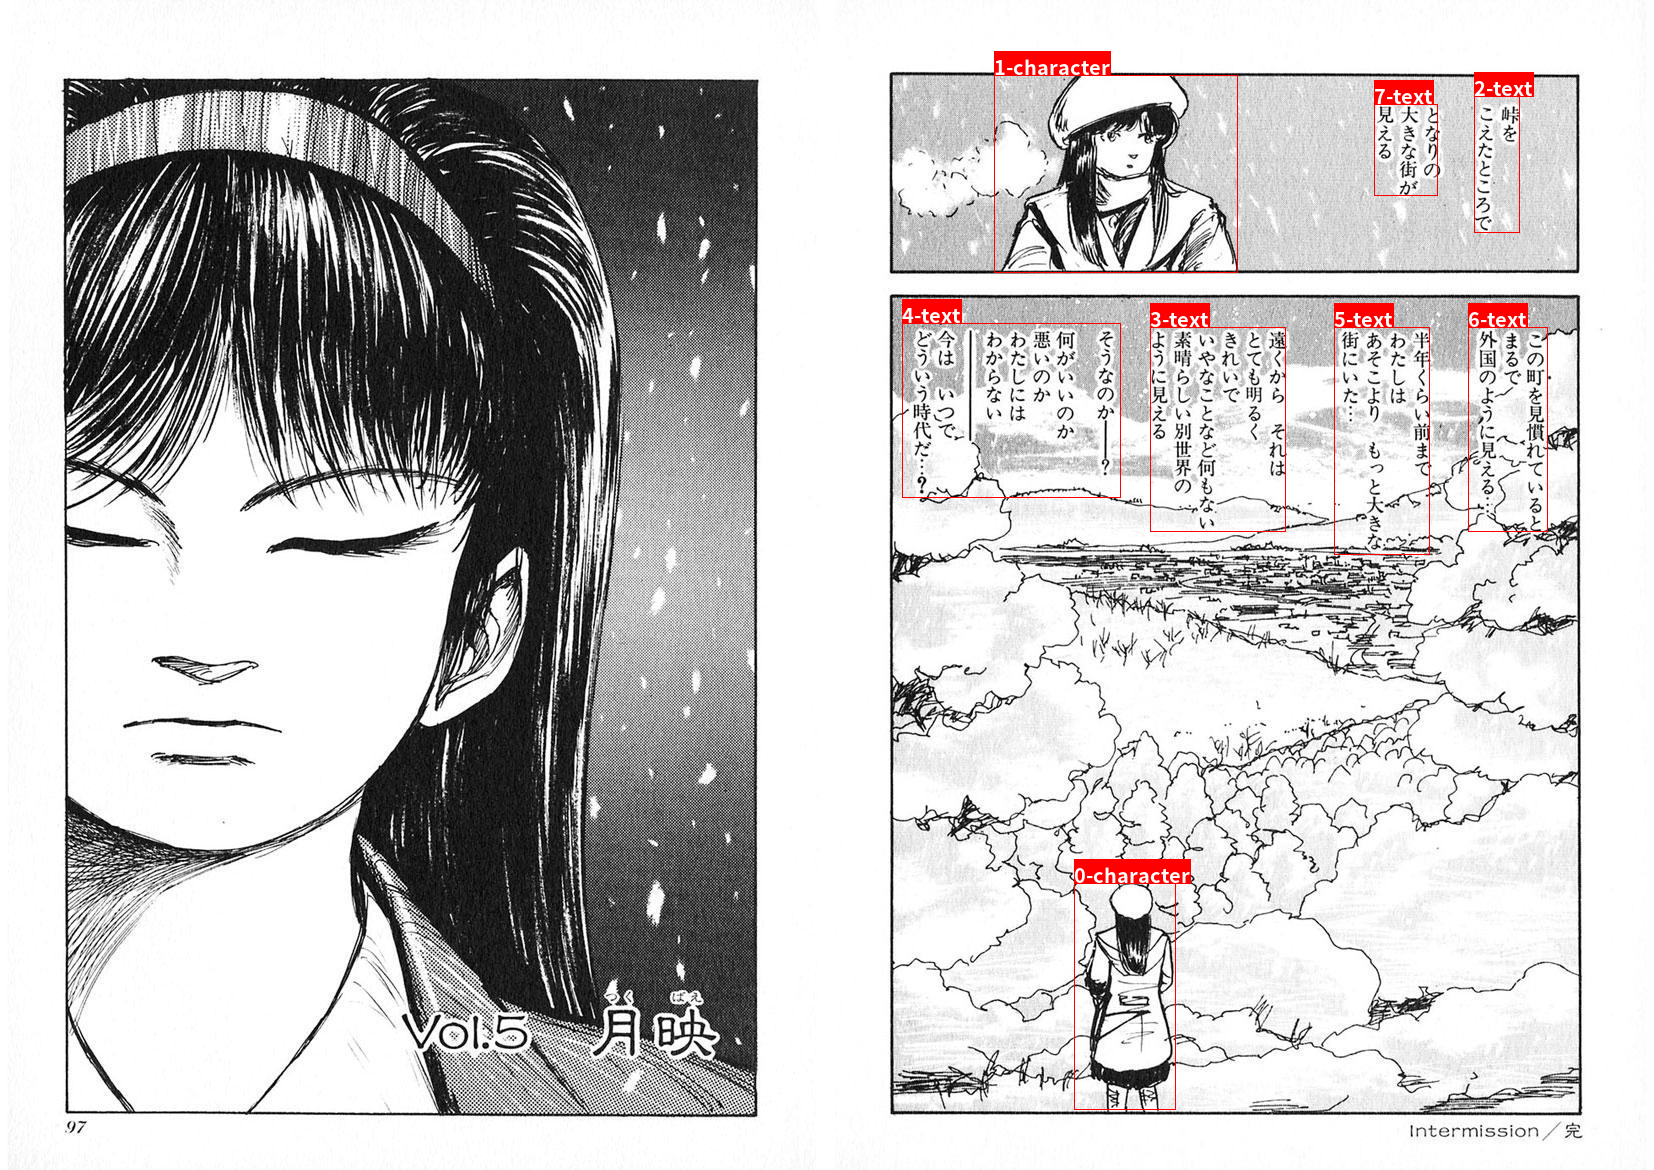

**************************************************
gt_boxes 0: 0-character
gt_boxes 1: 1-character
gt_boxes 2: 2-text
gt_boxes 3: 3-text
gt_boxes 4: 4-text
gt_boxes 5: 5-text
gt_boxes 6: 6-text
gt_boxes 7: 7-text
**************************************************
gt_rels 0: ('1-character', 'says', '7-text')
gt_rels 1: ('1-character', 'says', '2-text')
gt_rels 2: ('0-character', 'says', '4-text')
gt_rels 3: ('0-character', 'says', '6-text')
gt_rels 4: ('0-character', 'says', '5-text')
gt_rels 5: ('0-character', 'says', '3-text')
**************************************************


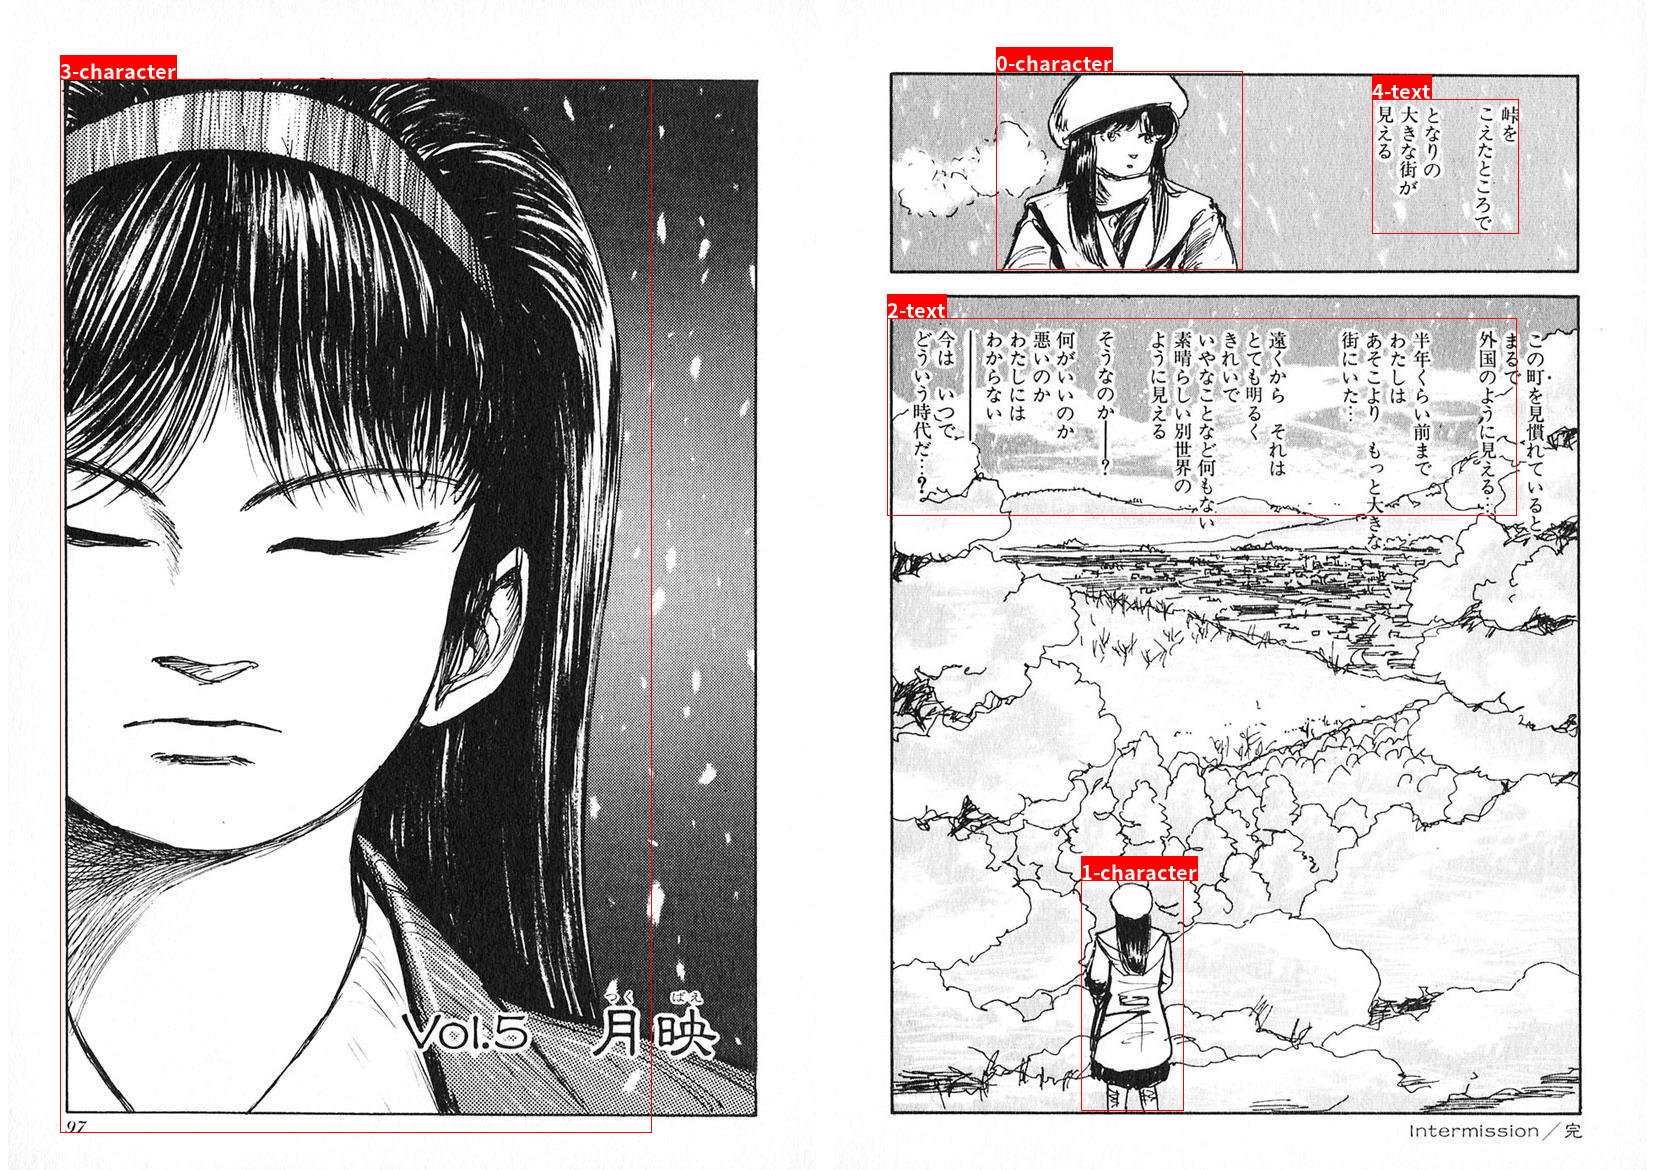

**************************************************
pred_labels 0: 0-character; score: 0.9991499185562134
pred_labels 1: 1-character; score: 0.9989659786224365
pred_labels 2: 2-text; score: 2.2628288576242994e-08
pred_labels 3: 3-character; score: 0.9996784925460815
pred_labels 4: 4-text; score: 0.9767910242080688
**************************************************
pred_rels 0: ('0-character', 'says', '4-text'); score: 0.9968277812004089
pred_rels 1: ('1-character', 'says', '4-text'); score: 0.031430572271347046
pred_rels 2: ('4-text', 'says', '0-character'); score: 5.384527685237117e-05
pred_rels 3: ('3-character', 'says', '4-text'); score: 3.6260399838283774e-07
pred_rels 4: ('0-character', 'says', '1-character'); score: 4.863527180987148e-08
pred_rels 5: ('1-character', 'says', '2-text'); score: 0.9909636974334717
pred_rels 6: ('4-text', 'says', '1-character'); score: 2.6655460061419944e-09
pred_rels 7: ('1-character', 'says', '0-character'); score: 5.913148304337312e-10
pred_rels 8: 

In [7]:
# show_all(start_idx=1, length=1)
show_selected([2837])